https://wikidocs.net/31379

# seq2seq 모델의 한계

인코더가 입력 시퀀스를 하나의 벡터로 압축하는 과정에서 입력 시퀀스의 정보가 일부 손실 -> attention

# hyper-parameter
<br>

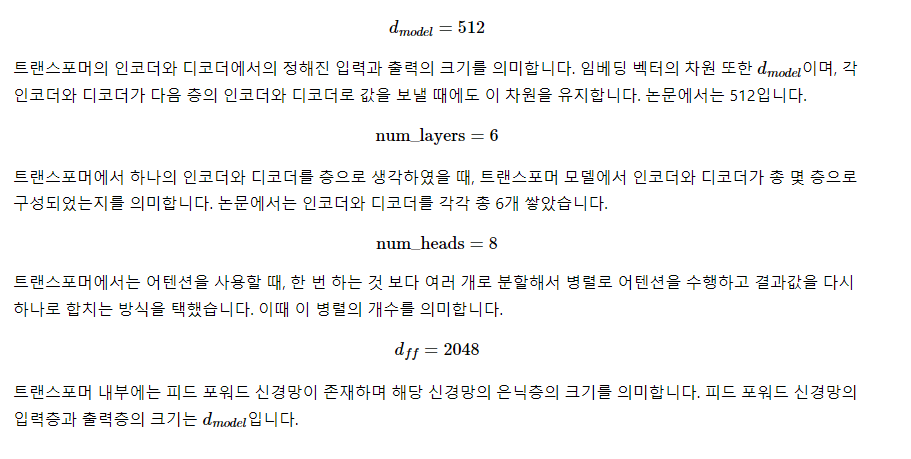

# Transformer
<br>

- RNN 사용x, RNN이 t개의 시점(time step)을 가지는 구조였다면 이번에는 인코더와 디코더라는 단위가 N개로 구성되는 구조
<br>
![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

- 인코더와 디코더는 단순히 각 단어의 임베딩 벡터들을 입력받는 것이 아니라 임베딩 벡터에서 조정된 값을 입력받음
<br>

***

### Positional Encoding
- RNN과 달리, 단어 입력을 순차적으로 받는 방식이 아니므로 단어의 위치 정보를 다른 방식으로 받아야 함. 
- 이를 위해서 각 단어의 '임베딩 벡터'에 '위치 정보들을 더하여' 모델의 입력으로 사용 -> **포지셔널 인코딩(positional encoding)**
<br>
<br>

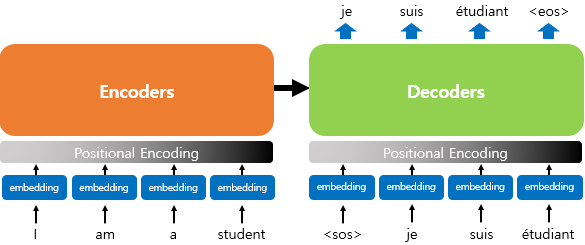

<br>

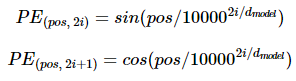 
<br>

- 임베딩 벡터가 모여 만들어진 문장 행렬과 포지셔널 인코딩 행렬의 덧셈 연산 즉,
<br>

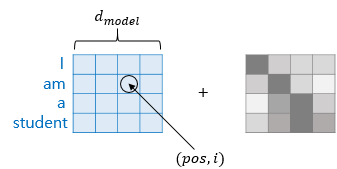

**pos** - 임베딩 벡터 위치

**i** - 임베딩 벡터 내의 차원의 인덱스
-> _i가 짝수이면 사인함수 / 홀수이면 코사인함수_
<br>

#### => 즉, 임베딩 벡터에 포지셔널 인코딩의 값을 더하면 같은 단어라고 하더라도 문장 내의 위치에 따라서 트랜스포머의 입력으로 들어가는 임베딩 벡터의 값이 달라짐. 이에 따라 트랜스포머의 입력은 '순서 정보'가 고려된 임베딩 벡터가 되는 것.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [ ]:
# 문장의 길이 50, 임베딩 벡터의 차원 128 = 단어가 50개&각 단어가 128차원의 임베딩 벡터를 가짐
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

(1, 50, 128)


## Attention

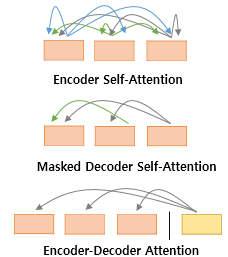
<br>
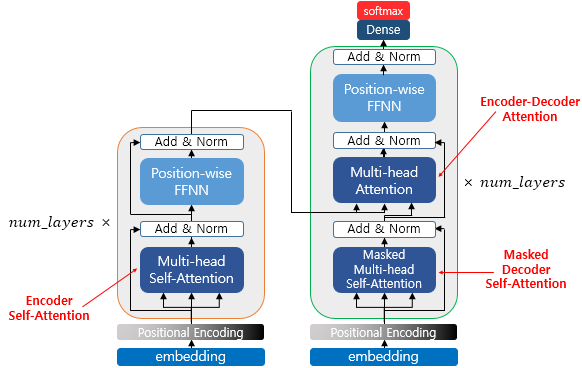
<br>




### Multi-head : transformer가 attention을 병렬적으로 수행

- self-attention = query=key=value (벡터의 값이 아니라 출처가 같다.)

**인코더의 셀프 어텐션** : Query = Key = Value

**디코더의 마스크드 셀프 어텐션** : Query = Key = Value

**디코더의 인코더-디코더 어텐션** : Query : 디코더 벡터 / Key = Value : 인코더 벡터
<br>

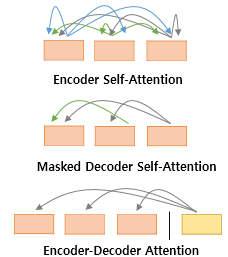
<br>
=> it? 셀프 어텐션은 입력 문장 내의 단어들끼리 유사도를 구하므로서 그것(it)이 동물(animal)과 연관되었을 확률이 높다는 것을 찾아냄


### 단어 벡터를 Q, K, V 벡터로 변환하는 과정
<br>

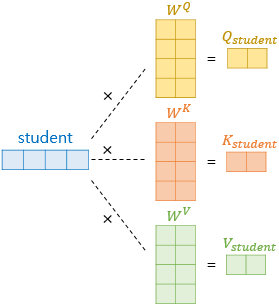

<br>

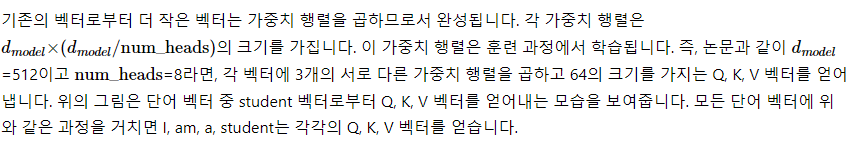

### Attention Score 구하기
### 1.Scaled dot-product Attention( 벡터마다 일일이 가중치 행렬 곱함)
<br>

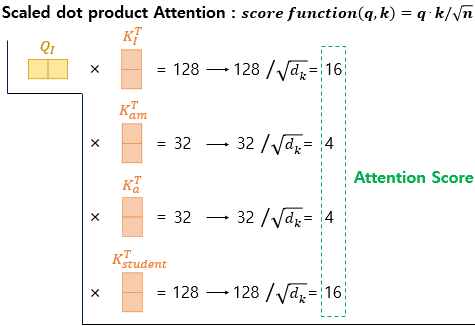

<br>

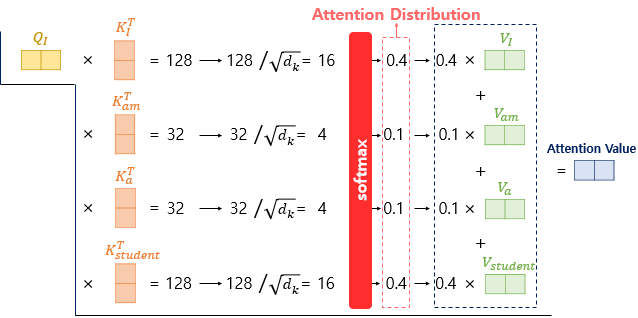

<br>

-> 이를 사용하여 모든 V벡터를 가중합하여 어텐션 값 또는 컨텍스트 벡터를 구함. 그리고 이를 모든 Q벡터에 대해서 반복

### 2. 행렬연산 일괄처리(문장 행렬에 가중치 행렬 곱함)
<br>

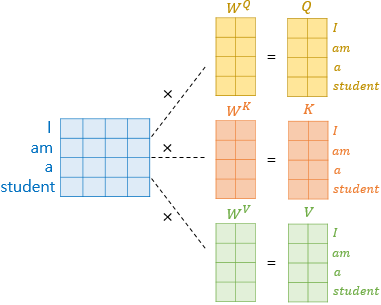

<br>

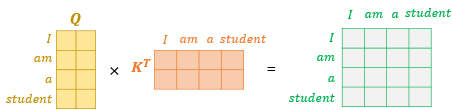

<br>

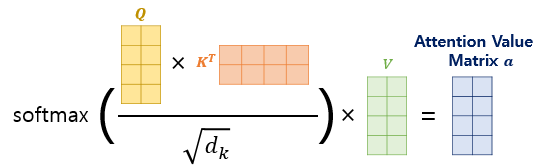

<br>

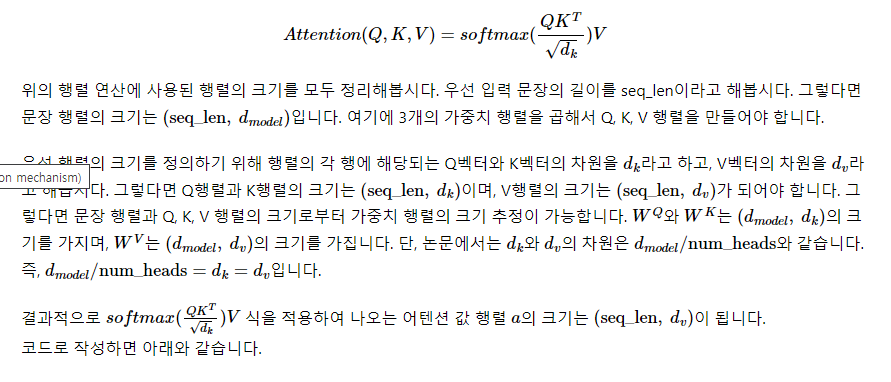


In [1]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [4]:
import numpy as np
import tensorflow as tf
# 임의의 Query, Key, Value인 Q, K, V 행렬 생성
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

In [5]:
# 함수 실행
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


Query는 4개의 Key값 중 두번째 값과 일치하므로 어텐션 분포는 [0, 1, 0, 0]의 값을 가지며 결과적으로 Value의 두번째 값인 [10, 0]이 출력되는 것을 확인할 수 있습니다. 이번에는 Query의 값만 다른 값으로 바꿔보고 함수를 실행해봅시다. 이번에 사용할 Query값 [0, 0, 10]은 Key의 세번째 값과, 네번째 값 두 개의 값 모두와 일치하는 값입니다.

In [6]:
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


Query의 값은 Key의 세번째 값과 네번째 값 두 개의 값과 모두 유사하다는 의미에서 어텐션 분포는 [0, 0, 0.5, 0.5]의 값을 가집니다. 결과적으로 나오는 값 [550, 5.5]는 Value의 세번째 값 [100, 5]에 0.5를 곱한 값과 네번째 값 [1000, 6]에 0.5를 곱한 값의 원소별 합입니다. 이번에는 하나가 아닌 3개의 Query의 값을 함수의 입력으로 사용해보겠습니다.

In [7]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)
